In [20]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
root_path = "/content/drive/My Drive/654/"
df = pd.read_csv(root_path + "creditcard.csv")  #total 284,807 transactions only 492 frauds
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
print(df.head(n=20))
train_df,val_df = train_test_split(df,test_size = 0.05)
#train_df.shape, val_df.shape  # ((270566, 31), (14241, 31))
LABEL_Columns = ["Time", 
            "V1","V2","V3","V4","V5",
            "V6","V7","V8","V9","V10",
            "V11","V12","V13","V14","V15",
            "V16","V17","V18","V19","V20",
            "V21","V22","V23","V24","V25",
            "V26","V27","V28",
            "Amount",  
            "Class"
]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Apr 21 22:31:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |   1072MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [21]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, latent_size, output_size, conditional=True):
        super().__init__()
        z = latent_size
        d = output_size
        if conditional:
            z = z + 1
        else:
            d = d + 1
        self.main = nn.Sequential(
            nn.Linear(z, 2 * latent_size),
            nn.ReLU(),
            nn.Linear(2 * latent_size, d),
            nn.Tanh
            )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, input_size, wasserstein=False):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size + 1, int(input_size / 2)),
            nn.ReLU(),
            nn.Linear(int(input_size / 2), 1),
            nn.Sigmoid
            )

    def forward(self, x):
        return self.main(x)

In [22]:
import torch
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score


def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def pate(data, netTD, lap_scale):
    results = torch.Tensor(len(netTD), data.size()[0]).type(torch.int64)
    for i in range(len(netTD)):
        output = netTD[i].forward(data)
        pred = (output > 0.5).type(torch.Tensor).squeeze()
        results[i] = pred

    clean_votes = torch.sum(results, dim=0).unsqueeze(1).type(torch.cuda.DoubleTensor)
    noise = torch.from_numpy(np.random.laplace(loc=0, scale=1/lap_scale, size=clean_votes.size())).cuda()
    #print(noise)
    noisy_results = clean_votes + noise
    noisy_labels = (noisy_results > len(netTD)/2).type(torch.cuda.DoubleTensor)

    return noisy_labels, clean_votes


def moments_acc(num_teachers, clean_votes, lap_scale, l_list):
    q = (2 + lap_scale * torch.abs(clean_votes - num_teachers) #todo original is 2 * clean votes
         )/(4 * torch.exp(lap_scale * torch.abs(clean_votes - num_teachers))) #todo original is 2 * clean votes

    update = []
    #print(q.shape,l_list.shape)
    for l in l_list:
        a = 2*lap_scale*lap_scale*l*(l + 1)
        t_one = (1 - q) * torch.pow((1 - q) / (1 - math.exp(2*lap_scale) * q), l)
        t_two = q * torch.exp(2*lap_scale * l)
        t = t_one + t_two
        t = torch.log(t)
        update.append(torch.clamp(t, max=a).sum())
        #print(update)

    return torch.cuda.DoubleTensor(update)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np
import math
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class PATE_GAN:
    def __init__(self, input_dim, z_dim, num_teachers, target_epsilon, target_delta, conditional=True):
        self.generator = Generator(z_dim, input_dim, conditional).cuda().double()
        self.student_disc = Discriminator(input_dim, wasserstein=False).cuda().double()
        self.teacher_disc = [Discriminator(input_dim, wasserstein=False).cuda().double()
                             for _ in range(num_teachers)]
        self.generator.apply(weights_init)
        self.student_disc.apply(weights_init)
        self.z_dim = z_dim
        self.num_teachers = num_teachers
        for i in range(num_teachers):
            self.teacher_disc[i].apply(weights_init)

        self.target_epsilon = target_epsilon
        self.target_delta = target_delta
        self.conditional = conditional

    def train(self, x_train, y_train, hyperparams):
        batch_size = hyperparams.batch_size
        num_teacher_iters = hyperparams.num_teacher_iters
        num_student_iters = hyperparams.num_student_iters
        num_moments = hyperparams.num_moments
        lap_scale = hyperparams.lap_scale
        class_ratios = None
        if self.conditional:
            class_ratios = torch.from_numpy(hyperparams.class_ratios)

        real_label = 1
        fake_label = 0

        alpha = torch.cuda.DoubleTensor([0.0 for _ in range(num_moments)])
        l_list = 1 + torch.cuda.DoubleTensor(range(num_moments))

        criterion = nn.BCELoss()
        #criterion = nn.MSELoss()
        optimizer_g = optim.Adam(self.generator.parameters(), lr=hyperparams.lr)
        optimizer_sd = optim.Adam(self.student_disc.parameters(), lr=hyperparams.lr)
        optimizer_td = [optim.Adam(self.teacher_disc[i].parameters(), lr=hyperparams.lr
                                   ) for i in range(self.num_teachers)]

        tensor_data = data_utils.TensorDataset(torch.cuda.DoubleTensor(x_train), torch.cuda.DoubleTensor(y_train))

        train_loader = []
        for teacher_id in range(self.num_teachers):
            start_id = teacher_id * len(tensor_data) / self.num_teachers
            end_id = (teacher_id + 1) * len(tensor_data) / self.num_teachers if teacher_id != (
                    self.num_teachers - 1) else len(tensor_data)

            train_loader.append(data_utils.DataLoader(torch.utils.data.Subset( \
                tensor_data, range(int(start_id), int(end_id))), batch_size=batch_size, shuffle=True))

        steps = 0
        max_steps = 1100
        epsilon = 0

        #while epsilon < self.target_epsilon and steps < max_steps:
        while steps < max_steps:
            # train the teacher discriminators
            for t_2 in range(num_teacher_iters):
                for i in range(self.num_teachers):
                    inputs, categories = None, None
                    for b, data in enumerate(train_loader[i], 0):
                        inputs, categories = data
                        break

                    # train with real
                    optimizer_td[i].zero_grad()
                    label = torch.full((inputs.size()[0],), real_label).cuda()
                    output = self.teacher_disc[i].forward(torch.cat([inputs, categories.unsqueeze(1).double()], dim=1))
                    #print(label.T.shape)
                    label = label.unsqueeze(1)
                    #print(label.shape,output.shape) #todo dimension matching problem

                    err_d_real = criterion(output, label.double())

                    #err_d_real.backward()

                    # train with fake
                    z = torch.Tensor(batch_size, self.z_dim).uniform_(0, 1).cuda()
                    label.fill_(fake_label)

                    
                    category = torch.multinomial(class_ratios,  inputs.size()[0], replacement=True).unsqueeze(1).cuda().double()
                    fake = self.generator(torch.cat([z.double(), category], dim=1))
                    output = self.teacher_disc[i].forward(torch.cat([fake.detach(), category], dim=1))
    

                    err_d_fake = criterion(output, label.double())
                    d_loss = (err_d_real+err_d_fake)/2
                    d_loss.backward()
                    #err_d_fake.backward()
                    optimizer_td[i].step()

            # train the student discriminator
            for t_3 in range(num_student_iters):
                optimizer_sd.zero_grad()
                z = torch.Tensor(batch_size, self.z_dim).uniform_(0, 1).cuda()

                
                category = torch.multinomial(class_ratios,  inputs.size()[0], replacement=True).unsqueeze(1).cuda().double()
                fake = self.generator(torch.cat([z.double(), category], dim=1))
                predictions, clean_votes = pate(torch.cat(
                    [fake.detach(), category], dim=1), self.teacher_disc, lap_scale)
                outputs = self.student_disc.forward(torch.cat([fake.detach(), category], dim=1))
  

                # update the moments
                alpha = alpha + moments_acc(self.num_teachers, clean_votes, lap_scale, l_list)

                # update student
                err_sd = criterion(outputs, predictions)
                err_sd.backward()
                optimizer_sd.step()

            # train the generator
            optimizer_g.zero_grad()
            z = torch.Tensor(batch_size, self.z_dim).uniform_(0, 1).cuda()
            label = torch.full((inputs.size()[0],), real_label).cuda()

            if self.conditional:
                category = torch.multinomial(class_ratios,  inputs.size()[0], replacement=True).unsqueeze(1).cuda().double()
                fake = self.generator(torch.cat([z.double(), category], dim=1))
                output = self.student_disc(torch.cat([fake, category.double()], dim=1))
            else:
                fake = self.generator(z.double())
                output = self.student_disc.forward(fake)


            label = label.unsqueeze(1) #label matching problem
            err_g = criterion(output, label.double())

            err_g.backward()
            optimizer_g.step()

            # Calculate the current privacy cost
            epsilon = min((alpha + math.log(1/self.target_delta)) / l_list)
            if steps % 100 == 0:
                print("Step : ", steps, "Loss SD : ", err_sd.item(), "Loss G : ", err_g.item(), "Epsilon : ",
                      epsilon.item())
                


            if steps % 1000 == 0 and steps != 0:
              from sklearn.linear_model import LogisticRegression
              from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
                  BaggingClassifier,AdaBoostClassifier,ExtraTreesClassifier
              from sklearn.tree import  DecisionTreeClassifier
              from sklearn.neural_network import MLPClassifier
              from sklearn.naive_bayes import  BernoulliNB, GaussianNB
              from sklearn.metrics import roc_auc_score, mean_squared_error
              import xgboost as xgb
              #get the synthesis data

              #test the results on learners
              learners = []
              names = ['BernoulliNB','LogisticRegression','xgb.XGBClassifier','Random Forest', 'BaggingClassifier','AdaBoostClassifier','ExtraTreesClassifier','DecisionTreeClassifier','Neural Network', 'GradientBoostingClassifier']
              learners.append((BernoulliNB()))
              learners.append((LogisticRegression()))
              learners.append((xgb.XGBClassifier(use_label_encoder=False)))
              learners.append((RandomForestClassifier()))
              learners.append((BaggingClassifier()))
              learners.append((AdaBoostClassifier()))
              learners.append((ExtraTreesClassifier()))
              learners.append((DecisionTreeClassifier()))
              learners.append((MLPClassifier(early_stopping=True)))
              learners.append((GradientBoostingClassifier()))
              print("AUC scores of downstream classifiers on test data : ")
              total_avg = 0
              for i in range(0, len(learners)):
                  #y_syn = np.expand_dims(y_syn, axis=0).T
                  #print(y_syn.shape)
                  avg_score = 0
                  for i2 in range(10):
                      #print(class_ratios)
                      syn_data = model.generate(X_train.shape[0], class_ratios = class_ratios.detach().cpu().numpy())
                      #train,val = train_test_split(syn_data,test_size = 0.05)
                      train = syn_data
                      X_syn, y_syn = train[:, :-1], train[:, -1]
                      #X_syn_v, y_syn_v = val[:, :-1], val[:, -1]
                      #print(y_syn)
                      score = learners[i].fit(X_syn, y_syn)
                      pred_probs = learners[i].predict_proba(X_train)
                      auc_score = roc_auc_score(y_train, pred_probs[:, 1])
                      #print(auc_score)
                      avg_score += auc_score
                  avg_score /=10
                  #print('-' * 40)
                  #print('{0}: {1}'.format(names[i], avg_score))
                  total_avg +=avg_score
              total_avg /=10
              print('-' * 40)
              print("total avg score: ", total_avg)

            steps += 1
    def generate(self, num_rows, class_ratios, batch_size=64):
        steps = num_rows // batch_size
        synthetic_data = []
        if self.conditional:
            class_ratios = torch.from_numpy(class_ratios)
        for step in range(steps):
            noise = torch.randn(batch_size, self.z_dim).cuda()
            
            cat = torch.multinomial(class_ratios, batch_size, replacement=True).unsqueeze(1).cuda().double()
            synthetic = self.generator(torch.cat([noise.double(), cat], dim=1))
            synthetic = torch.cat([synthetic, cat], dim=1)

            
            synthetic_data.append(synthetic.cpu().data.numpy())

        if steps * batch_size < num_rows:
            noise = torch.randn(num_rows - steps * batch_size, self.z_dim).cuda()

            cat = torch.multinomial(class_ratios, num_rows - steps * batch_size, replacement=True).unsqueeze(
                1).cuda().double()
            synthetic = self.generator(torch.cat([noise.double(), cat], dim=1))
            synthetic = torch.cat([synthetic, cat], dim=1)
            
            synthetic_data.append(synthetic.cpu().data.numpy())

        return np.concatenate(synthetic_data)



#Start....
#print(train_df.loc[train_df["Class"] == 1])
training_positive_samples = train_df.loc[train_df["Class"] == 1]
training_negative_samples = train_df.loc[train_df["Class"] == 0].sample(n=500)
training_samples = pd.concat([training_positive_samples,training_negative_samples])
training_samples = shuffle(training_samples)
print(training_samples.shape) #969


classfication = True
if classfication:
  class_ratios = training_samples["Class"].sort_values().groupby(training_samples["Class"]).size().values/training_samples.shape[0]
  conditional = True
else:
  class_ratios = None
print("class ratio", class_ratios)

X_train = np.nan_to_num(training_samples.drop(["Class"], axis=1).values)
y_train = np.nan_to_num(training_samples["Class"].values).T
X_val = np.nan_to_num(val_df.drop(["Class"], axis=1).values)
y_val = np.nan_to_num(val_df["Class"].values).T

input_dim = X_train.shape[1]
z_dim = int(input_dim / 4 + 1) if input_dim % 4 == 0 else int(input_dim / 4)

print(X_train.shape, y_train.shape)
print(X_val.shape,y_val.shape)


Hyperparams = collections.namedtuple(
        'Hyperarams',
        'batch_size num_teacher_iters num_student_iters num_moments lap_scale class_ratios lr')
Hyperparams.__new__.__defaults__ = (None, None, None, None, None, None, None)

num_teachers = 5
eplison = 10
lambda_ = num_teachers/(2*eplison)
torch.manual_seed(0)
print("inputdim",input_dim)
print("z_dim",z_dim)


model = PATE_GAN(input_dim, z_dim, num_teachers=5, target_epsilon =2, target_delta = 1e-5, conditional = conditional)
model.train(X_train, y_train, Hyperparams(batch_size=64, num_teacher_iters=1,num_student_iters=1, num_moments=64, lap_scale=1, class_ratios=class_ratios, lr=1e-5))

syn_data = model.generate(X_train.shape[0], class_ratios = class_ratios)
#train,val = train_test_split(syn_data,test_size = 0.05)
train = syn_data
X_syn, y_syn = train[:, :-1], train[:, -1]

(970, 31)
class ratio [0.51546392 0.48453608]
(970, 30) (970,)
(14241, 30) (14241,)
inputdim 30
z_dim 7
Step :  0 Loss SD :  0.963168385437183 Loss G :  0.39187922362314226 Epsilon :  65.17728346832865
Step :  100 Loss SD :  0.9753439136513712 Loss G :  0.40317581935107616 Epsilon :  4496.618235851981
Step :  200 Loss SD :  1.0190934480929812 Loss G :  0.3712234754936155 Epsilon :  8233.921872202074
Step :  300 Loss SD :  1.0552167770307144 Loss G :  0.3744641872728455 Epsilon :  11542.664223156411
Step :  400 Loss SD :  1.0467311486368214 Loss G :  0.37375422408433834 Epsilon :  14572.04196903165
Step :  500 Loss SD :  1.085850606248344 Loss G :  0.37015565127553074 Epsilon :  17343.9994687483
Step :  600 Loss SD :  1.0232637597704888 Loss G :  0.3928166180574456 Epsilon :  19900.987782501426
Step :  700 Loss SD :  1.0725467658547605 Loss G :  0.37289895477143303 Epsilon :  22217.42704823846
Step :  800 Loss SD :  1.165689105857366 Loss G :  0.3688510644669452 Epsilon :  24293.5553006

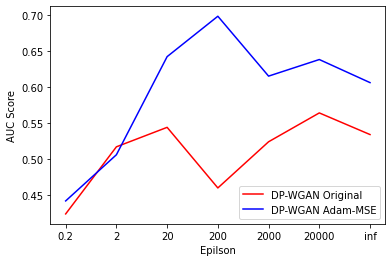

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(teacher1,teacher5,teacher100,teacher200):
    plt.figure()
    plt.xlabel("Eplison")
    plt.ylabel("AUC Score")

    plt.plot(teacher1, label="1 teachers", color="blue")
    plt.plot(teacher5, label="2 teachers", color="yellow")
    plt.plot(teacher100, label="5 teachers", color="green")
    plt.plot(teacher200, label="10 teachers", color="red")
    plt.xticks(np.linspace(0,6,7),['0.2','2','20','200','2000','20000','inf'])
    plt.ylim(0.5, 0.8)
    plt.legend()
    plt.show()
def showPlot2(list1):
    plt.figure()
    plt.xlabel("Epoches")
    plt.ylabel("AUC Score")

    plt.plot(list1, label="lap scale 0.1", color="blue")
    plt.xticks(np.linspace(0,8,9),['10','100','300','600','900','1800','3000','6000','12000'])
    plt.ylim(0.2, 1)
    plt.legend()
    plt.show()
  
def showPlot3(list_dp,list_pate):
    plt.figure()
    plt.xlabel("Epilson")
    plt.ylabel("AUC Score")
    plt.plot(list_dp, label="DP-WGAN", color="red")
    plt.plot(list_pate, label="PATE-GAN", color="blue")
    plt.xticks(np.linspace(0,6,7),['0.2','2','20','200','2000','20000','inf'])
    plt.legend()
    plt.show()

def showPlot4(list_dp,list_pate):
    plt.figure()
    plt.xlabel("Epilson")
    plt.ylabel("AUC Score")
    plt.plot(list_dp, label="DP-WGAN Original", color="red")
    plt.plot(list_pate, label="DP-WGAN Adam-MSE", color="blue")
    plt.xticks(np.linspace(0,6,7),['0.2','2','20','200','2000','20000','inf'])
    plt.legend()
    plt.show()


list1=[0.424,0.517,0.544,0.460,0.524,0.564,0.534]
list2=[0.442,0.506,0.642,0.698,0.615,0.638,0.606]

showPlot4(list1,list2)

(970, 31)
(47, 31)
(970, 2) (970, 1)
(970, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


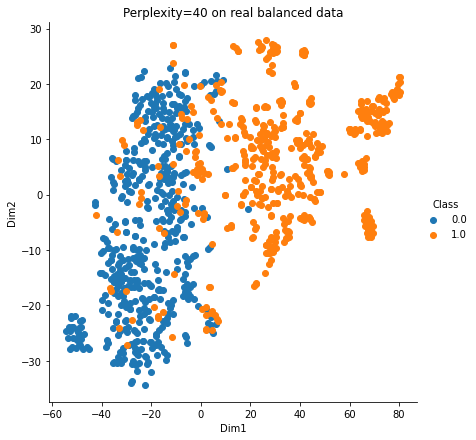

(970, 2) (970, 1)
(970, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


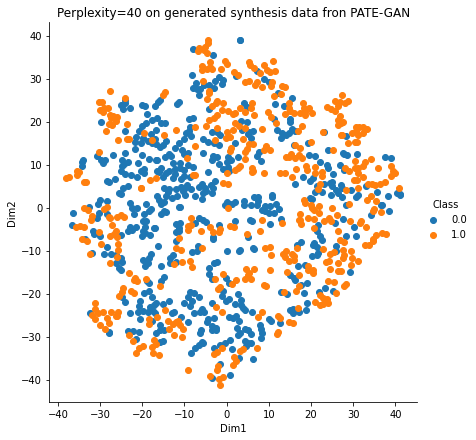

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
training_positive_samples = train_df.loc[train_df["Class"] == 1]
training_negative_samples = train_df.loc[train_df["Class"] == 0].sample(n=500)
training_samples = pd.concat([training_positive_samples,training_negative_samples])
training_samples = shuffle(training_samples)
print(training_samples.shape) #969
val_positive_samples = val_df.loc[val_df["Class"] == 1]
val_negative_samples = val_df.loc[val_df["Class"] == 0].sample(n=25)
val_samples = pd.concat([val_positive_samples,val_negative_samples])
val_samples = shuffle(val_samples)
print(val_samples.shape)


X_train = np.nan_to_num(training_samples.drop(["Class"], axis=1).values)
y_train = np.nan_to_num(training_samples["Class"].values).T
X_test = np.nan_to_num(val_samples.drop(["Class"], axis=1).values)
y_test = np.nan_to_num(val_samples["Class"].values).T

input_dim = X_train.shape[1]
z_dim = int(input_dim / 4 + 1) if input_dim % 4 == 0 else int(input_dim / 4)

scr = StandardScaler()
X_train = scr.fit_transform(X_train)
model_Tsne = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
embedded_data = model_Tsne.fit_transform(X_train)

y_train = np.expand_dims(y_train, axis=1)
print(embedded_data.shape,y_train.shape)
final_data = np.concatenate((embedded_data,y_train),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("Perplexity=40 on real balanced data")
plt.show()

#generated data


scr = StandardScaler()
X_syn = scr.fit_transform(X_syn)
model_Tsne = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
embedded_data = model_Tsne.fit_transform(X_syn)

y_syn = np.expand_dims(y_syn, axis=1)
print(embedded_data.shape,y_syn.shape)
final_data = np.concatenate((embedded_data,y_syn),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.title("Perplexity=40 on generated synthesis data fron PATE-GAN")
plt.show()

Base line: 
